# Setup

## Check for GPUs

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()


# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Install transformers Library

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.7 MB/s eta 0:00:00


# Loading Dataset

In [ ]:
import json
import pandas as pd
with open('train.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)
def unit_test1(df):
  if len(df.columns)!=2:
    return("please upload correct file")






In [ ]:
unit_test1(df)

In [ ]:
df['tag'].replace({False: 0, True: 1}, inplace=True)
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.head()

Number of training sentences: 6,769



,sentence,tag
0,A major change of direction is needed in Brita...,0
1,Said Conservative policies economic failure ca...,1
2,He told the Scottish Parliament on Wednesday t...,0
3,Engage in a debate over how redistributive thi...,1
4,"In fact, some may vote where the parents live.",0


In [ ]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.tag.values

# Tokenization & Preprocessing

1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []


for sent in sentences:

    encoded_sent = tokenizer.encode( sent, add_special_tokens = True)
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (655 > 512). Running this sequence through the model will result in indexing errors


Original:  A major change of direction is needed in Britain if it is to prosper, the shadow chancellor said as the Tory Party spring conference began.
Token IDs: [101, 1037, 2350, 2689, 1997, 3257, 2003, 2734, 1999, 3725, 2065, 2009, 2003, 2000, 4013, 17668, 1010, 1996, 5192, 7306, 2056, 2004, 1996, 17117, 2283, 3500, 3034, 2211, 1012, 102]


In [ ]:
total=0
for sen in sentences:
  if len(sen.split(' '))>64:
    total+=1

print('Max length: ', max([len(sen) for sen in input_ids]))

Max length:  655


In [ ]:
total

4

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

# Train and Validation sets split

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=13, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=13, test_size=0.1)

# DataLoader preperation

In [ ]:
import torch
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Train Classification model (BertForSequenceClassification)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,          
    output_attentions = False, 
    output_hidden_states = False
)


model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Hyperparameter tuning - Optimizer & Learning Rate Scheduler 





In [ ]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
learning_rate= [2e-5, 3e-5, 5e-5]

In [ ]:
for l_rate in learning_rate:
  optimizer = AdamW(model.parameters(), lr = l_rate,  eps = 1e-8 )
  #print(optimizer)


  # Number of training epochs
  epochs = 4

  # Total number of training steps is number of batches * number of epochs.
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  import random

  seed_val = 130

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # Store the average loss after each epoch so we can plot them.
  loss_values = []

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      #t0 = time.time()

      total_loss = 0

      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              print('  Batch {:>5,}  of  {:>5,}.    '.format(step, len(train_dataloader)))

          
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          model=model.to(device)
          model.zero_grad()        


          outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask, 
                      labels=b_labels)
          
          # loss value out of the tuple.
          loss = outputs[0]

          total_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over the training data.
      avg_train_loss = total_loss / len(train_dataloader)            
      
      # Store the loss value for plotting the learning curve.
      loss_values.append(avg_train_loss)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      #print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")
      model.eval()

      # Tracking variables 
      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          # Add batch to GPU
          batch = tuple(t.to(device) for t in batch)
          
          # Unpack the inputs from our dataloader
          b_input_ids, b_input_mask, b_labels = batch
          

          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              outputs = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask)
          
          # Get the "logits" output by the model. The "logits" are the output
          logits = outputs[0]

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          
          # Calculate the accuracy for this batch of test sentences.
          tmp_eval_accuracy = flat_accuracy(logits, label_ids)
          
          # Accumulate the total accuracy.
          eval_accuracy += tmp_eval_accuracy

          # Track the number of batches
          nb_eval_steps += 1

      # Report the final accuracy for this validation run.
      print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
      #print("  Validation took: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Training complete!")



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    191.    
  Batch    80  of    191.    
  Batch   120  of    191.    
  Batch   160  of    191.    

  Average training loss: 0.16

Running Validation...
  Accuracy: 0.96

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    191.    
  Batch    80  of    191.    
  Batch   120  of    191.    
  Batch   160  of    191.    

  Average training loss: 0.09

Running Validation...
  Accuracy: 0.97

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    191.    
  Batch    80  of    191.    
  Batch   120  of    191.    
  Batch   160  of    191.    

  Average training loss: 0.08

Running Validation...
  Accuracy: 0.97

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    191.    
  Batch    80  of    191.    
  Batch   120  of    191.    
  Batch   160  of    191.    

  Average training loss: 0.07

Running Validation...
  Accuracy: 0.97

Training complete!

======== Epoch 1 / 4 ========
Training...
 

Training


In [ ]:
optimizer = AdamW(model.parameters(), lr = 3e-5,  eps = 1e-8 )

## Training

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import random

seed_val = 13

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    #t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.    '.format(step, len(train_dataloader)))

         
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model=model.to(device)
        model.zero_grad()        


        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # loss value out of the tuple.
        loss = outputs[0]

        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    #print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        

        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    #print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    191.    
  Batch    80  of    191.    
  Batch   120  of    191.    
  Batch   160  of    191.    

  Average training loss: 0.05

Running Validation...
  Accuracy: 0.95

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    191.    
  Batch    80  of    191.    
  Batch   120  of    191.    
  Batch   160  of    191.    

  Average training loss: 0.03

Running Validation...
  Accuracy: 0.95

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    191.    
  Batch    80  of    191.    
  Batch   120  of    191.    
  Batch   160  of    191.    

  Average training loss: 0.04

Running Validation...
  Accuracy: 0.96

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    191.    
  Batch    80  of    191.    
  Batch   120  of    191.    
  Batch   160  of    191.    

  Average training loss: 0.03

Running Validation...
  Accuracy: 0.95

Training complete!


In [ ]:
% matplotlib inline

UsageError: Line magic function `%` not found.


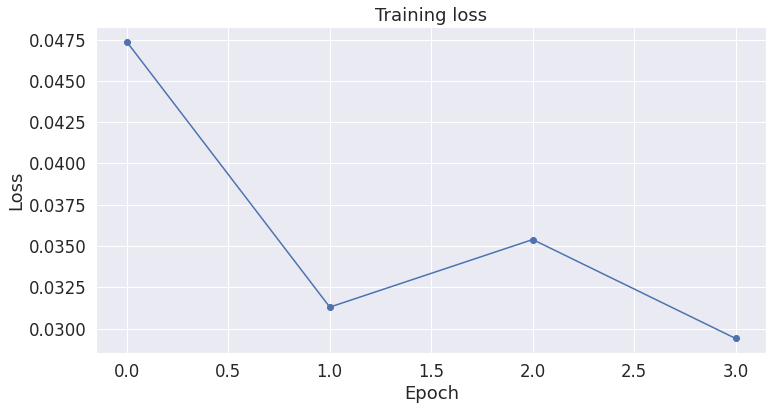

In [ ]:
import matplotlib.pyplot as plt


import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show();

# Performance in test Set

Matthew's correlation coefficient is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform this specific task.

## Test data preparation

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
import json
import pandas as pd
with open('test_1.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)

df['tag'].replace({False: 0, True: 1}, inplace=True)

print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.tag.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []


for sent in sentences:

    encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 996



In [ ]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient


for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.987


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(flat_true_labels,flat_predictions)

0.9949799196787149

# Test_2


In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
import json
import pandas as pd
with open('test_2.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)
unit_test1(df)

df['tag'].replace({False: 0, True: 1}, inplace=True)

print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.tag.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []


for sent in sentences:

    encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 999



In [ ]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient


for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.951


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(flat_true_labels,flat_predictions)

0.980980980980981

# Saving the model

In [ ]:
# tf.keras.models.save_model(model,'my_model1.h5')


In [ ]:
import os

output_dir = './model_save/'


if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')